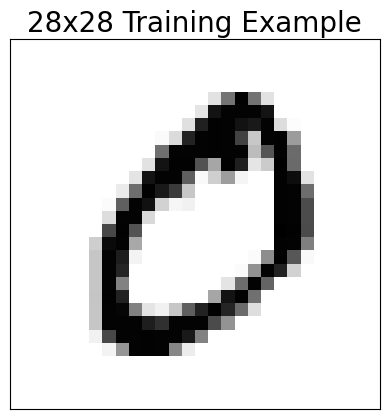

1/1 [==============================] - 11s 11s/step
Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1, 784)]          0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 126       
                                                                 
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
  1/396 [..............................] - ETA: 38:35:14 - loss: 0.9032 - accuracy: 0.5938

In [10]:
import numpy as np
import pandas as pd
import pennylane as qml
import tensorflow as tf
from matplotlib import pyplot as plt
import math

tf.keras.backend.set_floatx('float64')

class Preprocessing():

    def __init__(self, dataset):
        (x_train, y_train), (x_test, y_test) = dataset

        x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0

        self.x_train, self.y_train = self.filter_classes(x_train, y_train)
        self.x_test, self.y_test = self.filter_classes(x_test, y_test)
        
        self.plot(self.x_train[0, :, :, 0], '28x28 Training Example')
  
    def filter_classes(self, x, y):
        keep = (y == 0) | (y == 1)
        x, y = x[keep], y[keep]
        y = y == 0
        return x, y
    
    def plot(self, image, title, vmin = None, vmax = None):
        plt.imshow(image, cmap = 'Greys')
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(title, fontsize = 20)
        plt.show()


class QuantumNeuralNetwork():
    def __init__(self, x_train, y_train, x_test, y_test, epochs, layers, n_qubits):
        self.epochs = epochs
        self.n_qubits = n_qubits
        model = self.generate_model(x_train, layers = layers)
        model.compile(
            loss = tf.keras.losses.Hinge(),
            optimizer = tf.keras.optimizers.Adam(),
            metrics = [self.accuracy])
        history, results, model = self.train_model(model, x_train, y_train, x_test, y_test)
        model.save('FRQI.h5')
        history_df = pd.DataFrame(history.history)
        with open('FRQI.csv', mode = 'w') as f:
            history_df.to_csv(f)
        print('\nModel complete!\n')

    def generate_model(self, x_train, layers):
        n_layers = layers
        dev = qml.device('default.qubit', wires = self.n_qubits)
        
        def frqi_encoding(inputs):
            inputs = np.array(inputs).flatten()
            value_qubit = 0
            for pos, value in enumerate(inputs):
                # Apply controlled Y rotations to entangle the position qubits with the value qubit
                for i in range(self.n_qubits - 1):
                    qml.CRY(np.pi * value, wires=[i + 1, value_qubit])

                # Apply X gates to flip the position qubits based on the binary representation of the position
                for i in range(self.n_qubits - 1):
                    if (pos >> i + 1) & 1:
                        qml.PauliX(wires=i + 1)

        @qml.qnode(dev, diff_method = 'adjoint')
        def qnode(inputs, weights):
            frqi_encoding(inputs)

            for jj in range(n_layers):
                for ii in range(self.n_qubits - 1):
                    qml.RZ(weights[jj, 2 * ii, 0], wires = 0)
                    qml.RY(weights[jj, 2 * ii, 1], wires = 0)
                    qml.RZ(weights[jj, 2 * ii, 2], wires = 0)

                    qml.RZ(weights[jj, 2 * ii + 1, 0], wires = ii + 1)
                    qml.RY(weights[jj, 2 * ii + 1, 1], wires = ii + 1)
                    qml.RZ(weights[jj, 2 * ii + 1, 2], wires = ii + 1)

                    qml.CNOT(wires = [ii + 1, 0])
                    
                qml.RZ(weights[jj, 2 * (self.n_qubits - 1), 0], wires = 0)
                qml.RY(weights[jj, 2 * (self.n_qubits - 1), 1], wires = 0)
                qml.RZ(weights[jj, 2 * (self.n_qubits - 1), 2], wires = 0)

            return qml.expval(qml.PauliZ(0))

        weight_shapes = {'weights': (n_layers, 2 * (self.n_qubits - 1) + 1, 3)}
        qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim = 1, name = 'quantumLayer')
        inputs = tf.keras.Input(shape = (1, 784), name = 'inputs')
        outputs = qlayer(inputs)
        model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'QNN')
        #model.predict(x_train[0,:])
        x = np.reshape(x_train[0,:], (1, 784))
        x = x[np.newaxis, :]
        model.predict(x)
        print(model.summary())

        return model

    def train_model(self, model, x_train, y_train, x_test, y_test):
        EPOCHS = self.epochs
        BATCH_SIZE = 32
        NUM_EXAMPLES = x_train.shape[0]

        x_train_sub = np.reshape(x_train[:NUM_EXAMPLES, :], (NUM_EXAMPLES, 1, 784))

        y_train_hinge = 2.0 * y_train - 1.0
        y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

        x_test_sub = np.reshape(x_test[:, :], (x_test.shape[0], 1, 784))
        y_test_sub = y_test[:]

        qnn_history = model.fit(
            x_train_sub,
            y_train_hinge_sub,
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            verbose = 1,
            validation_data = (x_test_sub, y_test_sub))

        qnn_results = model.evaluate(x_test_sub, y_test_sub)

        return qnn_history, qnn_results, model


    def accuracy(self, y_true, y_pred):
        y_true = tf.squeeze(y_true) > 0.0
        y_pred = tf.squeeze(y_pred) > 0.0
        result = tf.cast(y_true == y_pred, tf.float32)

        return tf.reduce_mean(result)
    
def main():
    layers = 2
    epochs = 60
    dataset = Preprocessing(tf.keras.datasets.mnist.load_data())
    x_train, y_train, x_test, y_test = dataset.x_train, dataset.y_train, dataset.x_test, dataset.y_test
    QuantumNeuralNetwork(x_train, y_train, x_test, y_test, epochs, layers, n_qubits=11)

main()